In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import imutils

%matplotlib inline

In [2]:
COUGH_PATH = 'videos_final/cough/'
NOT_COUGH_PATH = 'videos_final/not_cough/'

cough_vids = os.listdir(COUGH_PATH)
not_cough_vids = os.listdir(NOT_COUGH_PATH)

if '.DS_Store' in cough_vids:
    cough_vids.remove('.DS_Store')
    
if '.DS_Store' in not_cough_vids:    
    not_cough_vids.remove('.DS_Store')

In [3]:
video_length = []

for vid in cough_vids:
    frames = []
    
    # read video
    cap = cv2.VideoCapture(COUGH_PATH + vid)
    success, frame = cap.read()
    while success:
        frames.append(frame)
        success, frame = cap.read()

    video_length.append(len(frames))
    
for vid in not_cough_vids:
    frames = []
    
    # read video
    cap = cv2.VideoCapture(NOT_COUGH_PATH + vid)
    success, frame = cap.read()
    while success:
        frames.append(frame)
        success, frame = cap.read()
    
    video_length.append(len(frames))

In [4]:
video_length.sort()
video_length[:10]

[4, 4, 6, 6, 8, 8, 9, 9, 9, 10]

In [5]:
MIN_LENGTH = 10
SIZE = 228 # reduce for faster training
DIM = 3 # for 3-color dimension

X = []
y = []

for vid in cough_vids:
    frames = []
    
    # read video
    cap = cv2.VideoCapture(COUGH_PATH + vid)
    success, frame = cap.read()
    while success:
        frame = cv2.resize(frame, (SIZE, SIZE))
        frames.append(frame)
        success, frame = cap.read()
        
    
    if len(frames) >= MIN_LENGTH:
        # append img array in X and label in Y
        X.append(frames[:10])
        y.append(1) # label 1 for coughing
        
for vid in not_cough_vids:
    frames = []
    
    # read video
    cap = cv2.VideoCapture(NOT_COUGH_PATH + vid)
    success, frame = cap.read()
    while success:
        frame = cv2.resize(frame, (SIZE, SIZE))
        frames.append(frame)
        success, frame = cap.read()
    
    if len(frames) >= MIN_LENGTH:
        # append img array in X and label in Y
        X.append(frames[:10])
        y.append(0) # label 0 for not coughing

In [6]:
X = np.asarray(X)
y = np.asarray(y)

In [7]:
X.shape

(459, 10, 228, 228, 3)

In [8]:
y.shape

(459,)

In [11]:
from sklearn.model_selection import train_test_split

random_state = 0
np.random.seed(random_state)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=random_state)

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(367, 10, 228, 228, 3) (367,)
(92, 10, 228, 228, 3) (92,)


In [29]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, Dropout, TimeDistributed, GlobalAveragePooling2D

#defining the model architecture

def create_cnn_model():    
    cnn = Sequential()
    cnn.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(SIZE, SIZE, DIM)))
    cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))
    cnn.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2), strides=2))
    cnn.add(Dropout(0.2))
    cnn.add(Flatten())
    return cnn

def create_model():
    model = Sequential()
    model.add(TimeDistributed(create_cnn_model()))
    model.add(LSTM(28, return_sequences=True))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [33]:
model = Sequential()

model.add(
    TimeDistributed(
        Conv2D(64, (3,3), 
            padding='same', strides=(2,2), activation='relu'),
        input_shape = (10, SIZE, SIZE, 3)
    )
)
model.add(
    TimeDistributed( 
        Conv2D(64, (3,3), 
            padding='same', strides=(2,2), activation='relu')
    )
)

model.add(
    TimeDistributed(
        GlobalAveragePooling2D() # Or Flatten()
    )
)
model.add(
    LSTM(1024, activation='relu', return_sequences=False)
)

model.add(Dense(1024, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 10, 114, 114, 64)  1792      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 10, 57, 57, 64)    36928     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 10, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1024)              4460544   
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)               

In [34]:
model.fit(train_X, train_y, epochs=50, validation_split=0.2, batch_size=64)

Train on 293 samples, validate on 74 samples
Epoch 1/50
293/293 [==============================] - 75s 254ms/step - loss: 21.4590 - accuracy: 0.5154 - val_loss: 1.4907 - val_accuracy: 0.4865
Epoch 2/50
293/293 [==============================] - 60s 205ms/step - loss: 1.1389 - accuracy: 0.4608 - val_loss: 1.3013 - val_accuracy: 0.4865
Epoch 3/50
293/293 [==============================] - 57s 195ms/step - loss: 0.8906 - accuracy: 0.5495 - val_loss: 0.7378 - val_accuracy: 0.4865
Epoch 4/50
293/293 [==============================] - 52s 178ms/step - loss: 0.7456 - accuracy: 0.4915 - val_loss: 0.7194 - val_accuracy: 0.5135
Epoch 5/50
293/293 [==============================] - 51s 173ms/step - loss: 0.7323 - accuracy: 0.4710 - val_loss: 0.6951 - val_accuracy: 0.4865
Epoch 6/50
293/293 [==============================] - 48s 162ms/step - loss: 0.7065 - accuracy: 0.4778 - val_loss: 0.6932 - val_accuracy: 0.5135
Epoch 7/50
293/293 [==============================] - 50s 172ms/step - loss: 0.6991 

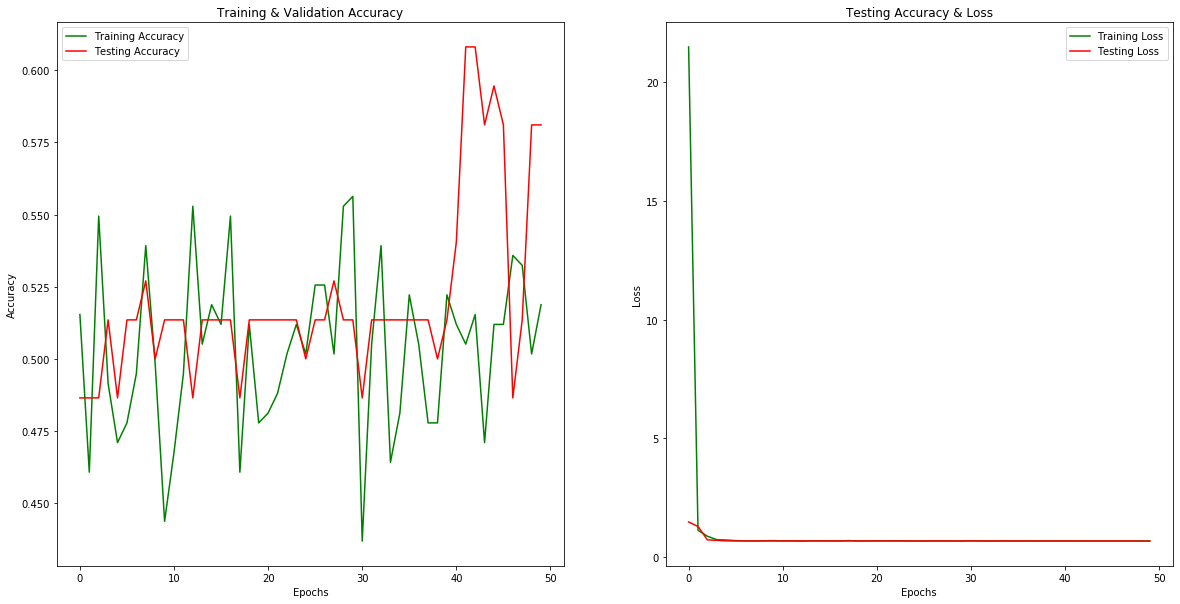

In [35]:
epochs = [i for i in range(len(model.history.history['val_loss']))]
fig , ax = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [36]:
print("Loss of the model is - " , model.evaluate(test_X,test_y)[0])
print("Accuracy of the model is - " , model.evaluate(test_X,test_y)[1]*100 , "%")

92/92 [==============================] - 5s 52ms/step
Loss of the model is -  0.6946780655695044
92/92 [==============================] - 4s 46ms/step
Accuracy of the model is -  42.391303181648254 %


In [21]:
# creating the CNN-LSTM model
model = create_model()

# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 